In [10]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3g52pbh5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3g52pbh5
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done


In [2]:
!pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.4 which is

In [1]:
import cv2
import pandas as pd
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cv2


In [2]:

# === Step 1: Setup Detectron2 Keypoint Model ===
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # confidence threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)



model_final_a6e10b.pkl: 237MB [00:03, 76.6MB/s]                           


In [3]:
# === Step 2: Open Video File ===
def generateCSV(videoPath, videoCSVName):
  video_path = videoPath # change to your video file path
  cap = cv2.VideoCapture(video_path)

  keypoints_data = []
  frame_id = 0

  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    outputs = predictor(frame)
    instances = outputs["instances"]

    if instances.has("pred_keypoints"):
        keypoints = instances.pred_keypoints.cpu().numpy()

        for person_id, person_kpts in enumerate(keypoints):
            for kpt_idx, (x, y, score) in enumerate(person_kpts):
                keypoints_data.append({
                    "frame_id": frame_id,
                    "person_id": person_id,
                    "keypoint_index": kpt_idx,
                    "x": float(x),
                    "y": float(y),
                    "score": float(score)
                })

    frame_id += 1

  cap.release()

  # === Step 3: Save to CSV ===
  df = pd.DataFrame(keypoints_data)
  df.to_csv(videoCSVName, index=False)
  print("Keypoints saved to - " , videoCSVName)
  #return videoCSVName


In [4]:
generateCSV("/content/adultDanceVideo.mp4", "vidy1_keypoints_output.csv")

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Keypoints saved to -  vidy1_keypoints_output.csv


In [5]:
generateCSV("/content/kidDanceVideo.mp4", "vidy2_keypoints_output.csv")

Keypoints saved to -  vidy2_keypoints_output.csv


Saved pose similarity summary to pose_comparison_summary.csv


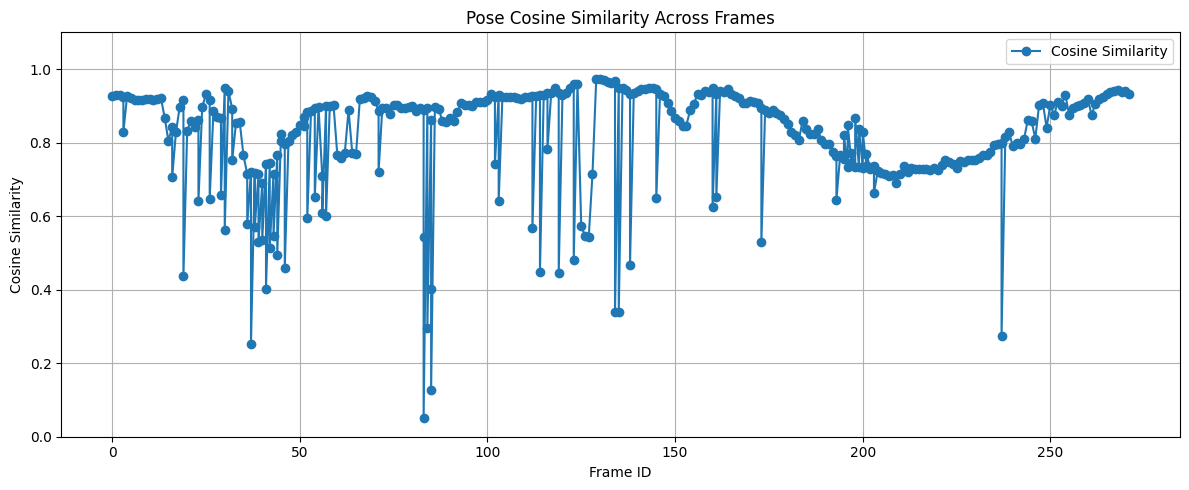

In [6]:


def normalize_pose(kpts):
    """ Center and scale pose. Input: (17, 2) keypoints """
    center = np.mean(kpts, axis=0)
    kpts_centered = kpts - center
    scale = np.linalg.norm(kpts_centered)
    if scale > 0:
        kpts_normalized = kpts_centered / scale
    else:
        kpts_normalized = kpts_centered
    return kpts_normalized

def pose_similarity(pose1, pose2):
    """ Cosine similarity and Euclidean distance """
    pose1_flat = pose1.flatten()
    pose2_flat = pose2.flatten()
    cos_sim = cosine_similarity([pose1_flat], [pose2_flat])[0, 0]
    eucl_dist = np.linalg.norm(pose1_flat - pose2_flat)
    return cos_sim, eucl_dist

# === Load and merge data ===
df1 = pd.read_csv("vidy1_keypoints_output.csv")
df2 = pd.read_csv("vidy2_keypoints_output.csv")

# Merge only common frame_id, person_id, keypoint_index
merged = pd.merge(df1, df2, on=["frame_id", "person_id", "keypoint_index"], suffixes=("_1", "_2"))

# Prepare pose comparisons
pose_comparisons = []

# Group by frame/person
for (frame_id, person_id), group in merged.groupby(["frame_id", "person_id"]):
    kpts1 = group[["x_1", "y_1"]].values
    kpts2 = group[["x_2", "y_2"]].values

    if kpts1.shape[0] == 17 and kpts2.shape[0] == 17:
        norm_pose1 = normalize_pose(kpts1)
        norm_pose2 = normalize_pose(kpts2)

        cos_sim, eucl_dist = pose_similarity(norm_pose1, norm_pose2)

        pose_comparisons.append({
            "frame_id": frame_id,
            "person_id": person_id,
            "cosine_similarity": cos_sim,
            "euclidean_distance": eucl_dist
        })

# === Save and visualize ===
df_pose = pd.DataFrame(pose_comparisons)
df_pose.to_csv("pose_comparison_summary.csv", index=False)
print("Saved pose similarity summary to pose_comparison_summary.csv")

# === Visualization ===
plt.figure(figsize=(12, 5))
plt.plot(df_pose["frame_id"], df_pose["cosine_similarity"], marker='o', label="Cosine Similarity")
plt.title("Pose Cosine Similarity Across Frames")
plt.xlabel("Frame ID")
plt.ylabel("Cosine Similarity")
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("pose_cosine_similarity.png")
plt.show()


In [7]:
COCO_SKELETON = [
    (5, 7), (7, 9),    # Left arm
    (6, 8), (8, 10),   # Right arm
    (5, 6),            # Shoulders
    (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (11, 12),          # Hips
    (5, 11), (6, 12)   # Torso
]

import cv2
import numpy as np

def draw_pose(image, keypoints, color=(0, 255, 0), threshold=0.3):
    for i, (x, y, score) in enumerate(keypoints):
        if score > threshold:
            cv2.circle(image, (int(x), int(y)), 3, color, -1)

    for i, j in COCO_SKELETON:
        if keypoints[i][2] > threshold and keypoints[j][2] > threshold:
            pt1 = (int(keypoints[i][0]), int(keypoints[i][1]))
            pt2 = (int(keypoints[j][0]), int(keypoints[j][1]))
            cv2.line(image, pt1, pt2, color, 2)
    return image

import pandas as pd
import os

# Load keypoints
df1 = pd.read_csv("vidy1_keypoints_output.csv")
df2 = pd.read_csv("vidy2_keypoints_output.csv")

# Open videos
cap1 = cv2.VideoCapture("/content/adultDanceVideo.mp4")
cap2 = cv2.VideoCapture("/content/kidDanceVideo.mp4")

# Output directory
os.makedirs("pose_overlays", exist_ok=True)

frame_id = 0
while cap1.isOpened() and cap2.isOpened():
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    if not ret1 or not ret2:
        break

    # Get keypoints for this frame
    kpts1 = df1[df1["frame_id"] == frame_id]
    kpts2 = df2[df2["frame_id"] == frame_id]

    # Draw each person
    for person_id in kpts1["person_id"].unique():
        person_kpts = kpts1[kpts1["person_id"] == person_id][["x", "y", "score"]].values
        if person_kpts.shape[0] == 17:
            frame1 = draw_pose(frame1, person_kpts)

    for person_id in kpts2["person_id"].unique():
        person_kpts = kpts2[kpts2["person_id"] == person_id][["x", "y", "score"]].values
        if person_kpts.shape[0] == 17:
            frame2 = draw_pose(frame2, person_kpts, color=(0, 0, 255))

    # Resize to match
    frame1 = cv2.resize(frame1, (480, 360))
    frame2 = cv2.resize(frame2, (480, 360))
    combined = cv2.hconcat([frame1, frame2])

    # Annotate
    cv2.putText(combined, f"Frame {frame_id}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    # Save
    cv2.imwrite(f"pose_overlays/frame_{frame_id:04d}.png", combined)
    frame_id += 1

cap1.release()
cap2.release()
print("Overlays saved to ./pose_overlays/")


Overlays saved to ./pose_overlays/


In [8]:
import cv2
import pandas as pd
import numpy as np
import os

# === COCO Skeleton Connections ===
COCO_SKELETON = [
    (5, 7), (7, 9), (6, 8), (8, 10),  # Arms
    (5, 6),                           # Shoulders
    (11, 13), (13, 15), (12, 14), (14, 16),  # Legs
    (11, 12),                         # Hips
    (5, 11), (6, 12)                  # Torso
]

# === Draw Skeleton Function ===
def draw_skeleton(image, keypoints, color=(0, 255, 0), threshold=0.3):
    for i, (x, y, score) in enumerate(keypoints):
        if score > threshold:
            cv2.circle(image, (int(x), int(y)), 3, color, -1)
    for i, j in COCO_SKELETON:
        if keypoints[i][2] > threshold and keypoints[j][2] > threshold:
            pt1 = (int(keypoints[i][0]), int(keypoints[i][1]))
            pt2 = (int(keypoints[j][0]), int(keypoints[j][1]))
            cv2.line(image, pt1, pt2, color, 2)
    return image

# === Load Keypoints CSV ===
df1 = pd.read_csv("vidy1_keypoints_output.csv")
df2 = pd.read_csv("vidy2_keypoints_output.csv")

# === Output Folder ===
os.makedirs("skeleton_video_frames", exist_ok=True)

# === Settings ===
width, height = 480, 360
background_color = (0, 0, 0)
frame_ids = sorted(set(df1["frame_id"]) & set(df2["frame_id"]))

for frame_id in frame_ids:
    # Create black background canvas
    left_canvas = np.full((height, width, 3), background_color, dtype=np.uint8)
    right_canvas = np.full((height, width, 3), background_color, dtype=np.uint8)

    # Draw Video 1 skeleton(s)
    frame_kpts1 = df1[df1["frame_id"] == frame_id]
    for person_id in frame_kpts1["person_id"].unique():
        kpts = frame_kpts1[frame_kpts1["person_id"] == person_id][["x", "y", "score"]].values
        if kpts.shape[0] == 17:
            draw_skeleton(left_canvas, kpts, color=(0, 255, 0))

    # Draw Video 2 skeleton(s)
    frame_kpts2 = df2[df2["frame_id"] == frame_id]
    for person_id in frame_kpts2["person_id"].unique():
        kpts = frame_kpts2[frame_kpts2["person_id"] == person_id][["x", "y", "score"]].values
        if kpts.shape[0] == 17:
            draw_skeleton(right_canvas, kpts, color=(0, 0, 255))

    # Combine side-by-side
    combined = cv2.hconcat([left_canvas, right_canvas])
    cv2.putText(combined, f"Frame {frame_id}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    # Save frame
    out_path = f"skeleton_video_frames/frame_{frame_id:04d}.png"
    cv2.imwrite(out_path, combined)

print("Skeleton frames saved to ./skeleton_video_frames")


Skeleton frames saved to ./skeleton_video_frames


In [9]:
import cv2
from moviepy.editor import VideoFileClip, clips_array

# --- Fake Skeletonization using Contour Detection ---
def fake_skeletonize_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    fgbg = cv2.createBackgroundSubtractorMOG2()

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        fgmask = fgbg.apply(frame)
        contours, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw contours (approximation of motion/silhouette)
        skeleton_frame = frame.copy()
        cv2.drawContours(skeleton_frame, contours, -1, (0, 255, 0), 2)
        out.write(skeleton_frame)

    cap.release()
    out.release()

# --- Combine Videos Side-by-Side ---
def combine_videos(video1_path, video2_path, output_path):
    clip1 = VideoFileClip(video1_path)
    clip2 = VideoFileClip(video2_path)

    # Resize to same height
    min_height = min(clip1.h, clip2.h)
    clip1 = clip1.resize(height=min_height)
    clip2 = clip2.resize(height=min_height)

    final_clip = clips_array([[clip1, clip2]])
    final_clip.write_videofile(output_path, audio=False)

# --- Main Execution ---
if __name__ == '__main__':
    input1 = '/content/adultDanceVideo.mp4'
    input2 = '/content/kidDanceVideo.mp4'
    skel1 = 'skeleton1.mp4'
    skel2 = 'skeleton2.mp4'
    output_combined = 'combined_skeleton_fake.mp4'

    print("Simulating skeletonization for first video...")
    fake_skeletonize_video(input1, skel1)

    print("Simulating skeletonization for second video...")
    fake_skeletonize_video(input2, skel2)

    print("Combining both skeletonized videos side-by-side...")
    combine_videos(skel1, skel2, output_combined)

    print("Done! Combined video saved as:", output_combined)


  if event.key is 'enter':



Simulating skeletonization for first video...
Simulating skeletonization for second video...
Combining both skeletonized videos side-by-side...
Moviepy - Building video combined_skeleton_fake.mp4.
Moviepy - Writing video combined_skeleton_fake.mp4



Moviepy - Done !
Moviepy - video ready combined_skeleton_fake.mp4
Done! Combined video saved as: combined_skeleton_fake.mp4
